--- Basic Statistics for 170_UCR_Anomaly_gaitHunt1_18500_33070_33180.txt ---
             Signal
count  64000.000000
mean    -718.665491
std      875.262129
min    -1951.000000
25%    -1812.000000
50%     -254.000000
75%       36.000000
max      425.733330


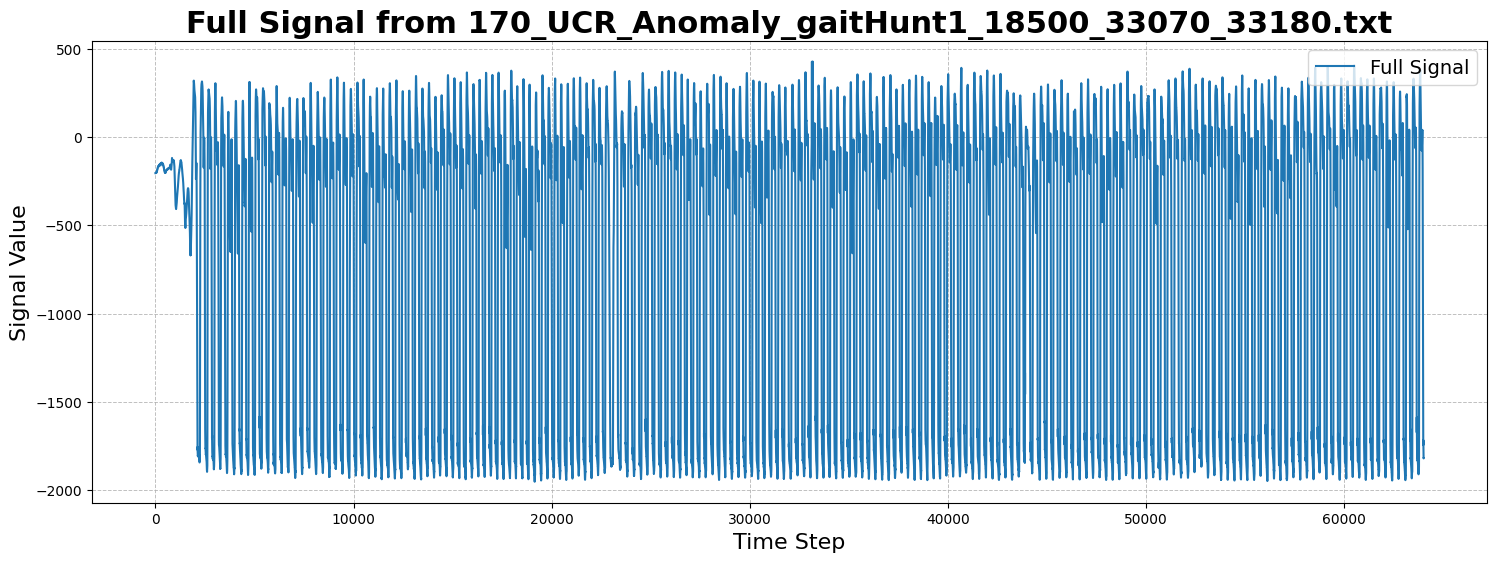

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def load_full_signal(path):
    return np.loadtxt(path).flatten()

def display_statistics_and_plot(signal, file_path):
    print(f"--- Basic Statistics for {file_path} ---")
    
    df = pd.DataFrame(signal, columns=['Signal'])
    print(df.describe())

    plt.figure(figsize=(18, 6))
    plt.plot(signal, label='Full Signal')
    plt.title('Full Signal from ' + file_path, fontsize=22, fontweight='bold')
    plt.xlabel('Time Step', fontsize=16)
    plt.ylabel('Signal Value', fontsize=16)
    plt.grid(True, linestyle='--', linewidth=0.7, alpha=0.8)
    plt.legend(loc='upper right', fontsize=14)
    plt.show()

def main():
    file_path = '170_UCR_Anomaly_gaitHunt1_18500_33070_33180.txt'
    full_signal = load_full_signal(file_path)
    display_statistics_and_plot(full_signal, file_path)

if __name__ == '__main__':
    main()

--- Running Comparison Algorithms on Original Signal ---
-> Processing: Pelt (L2)...


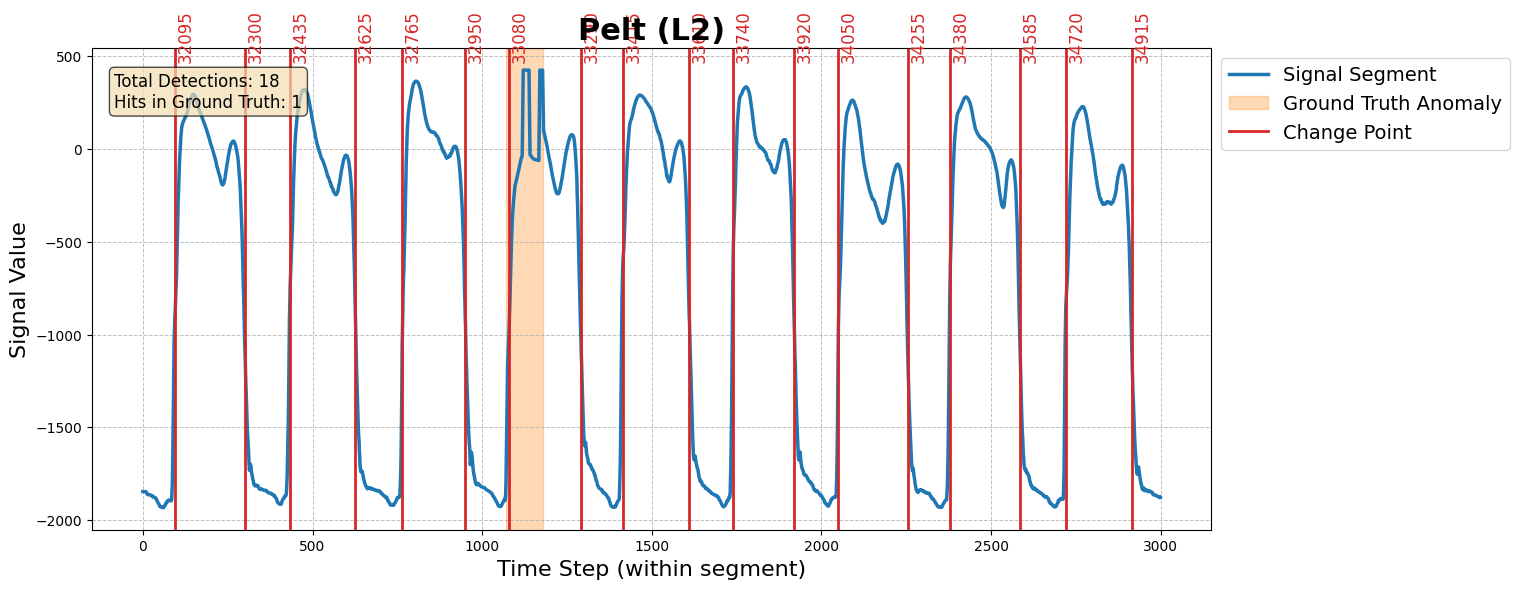

-> Processing: BinSeg (L2)...


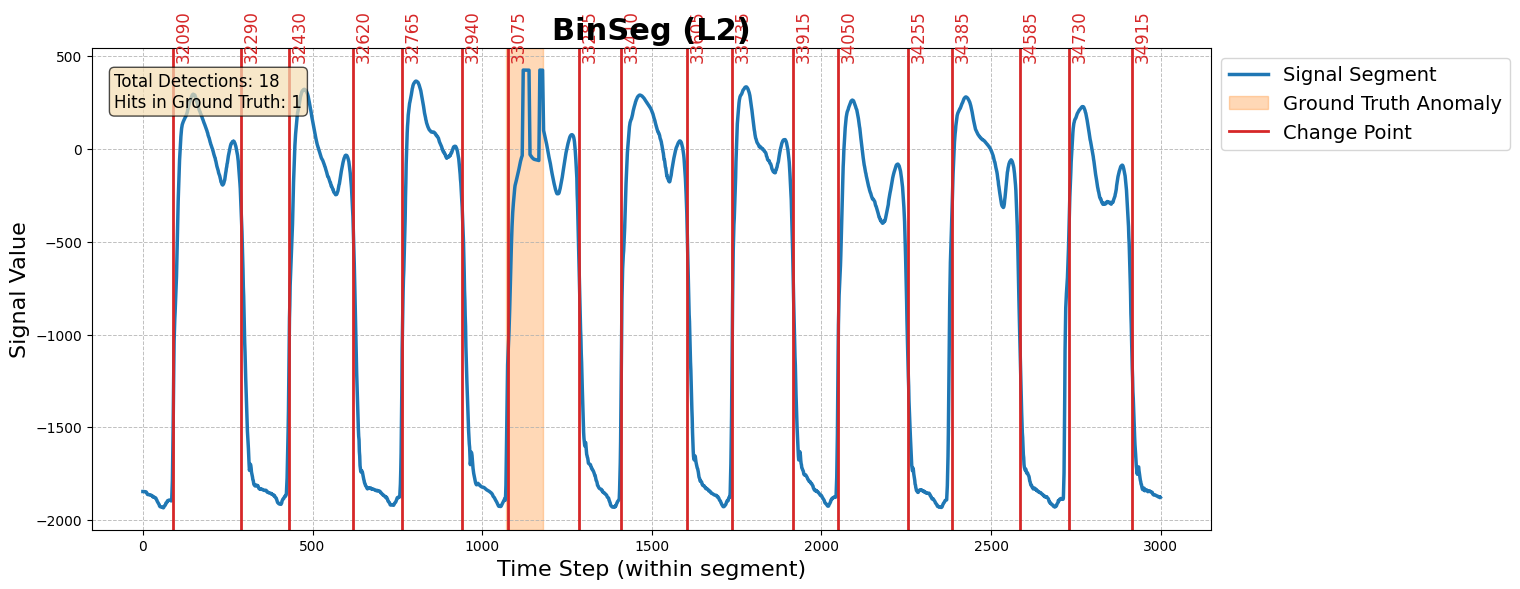

-> Processing: Window (L2)...


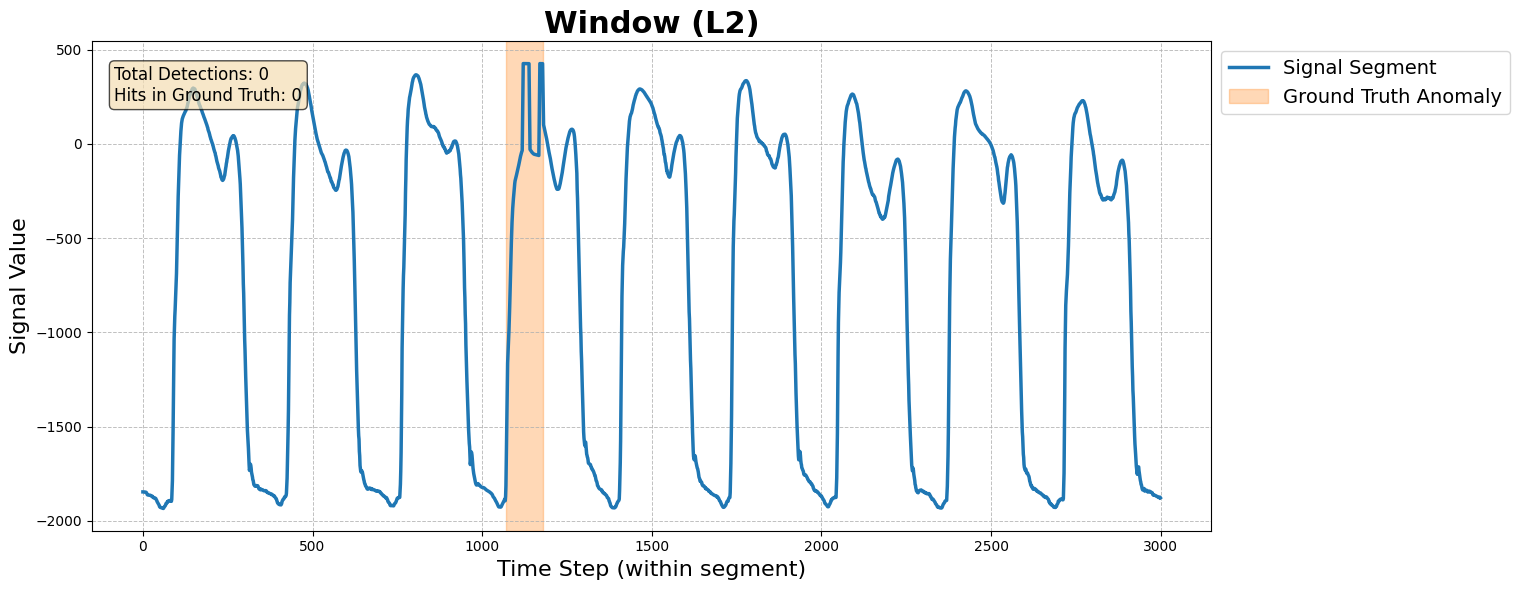

-> Processing: KernelCPD (Linear)...


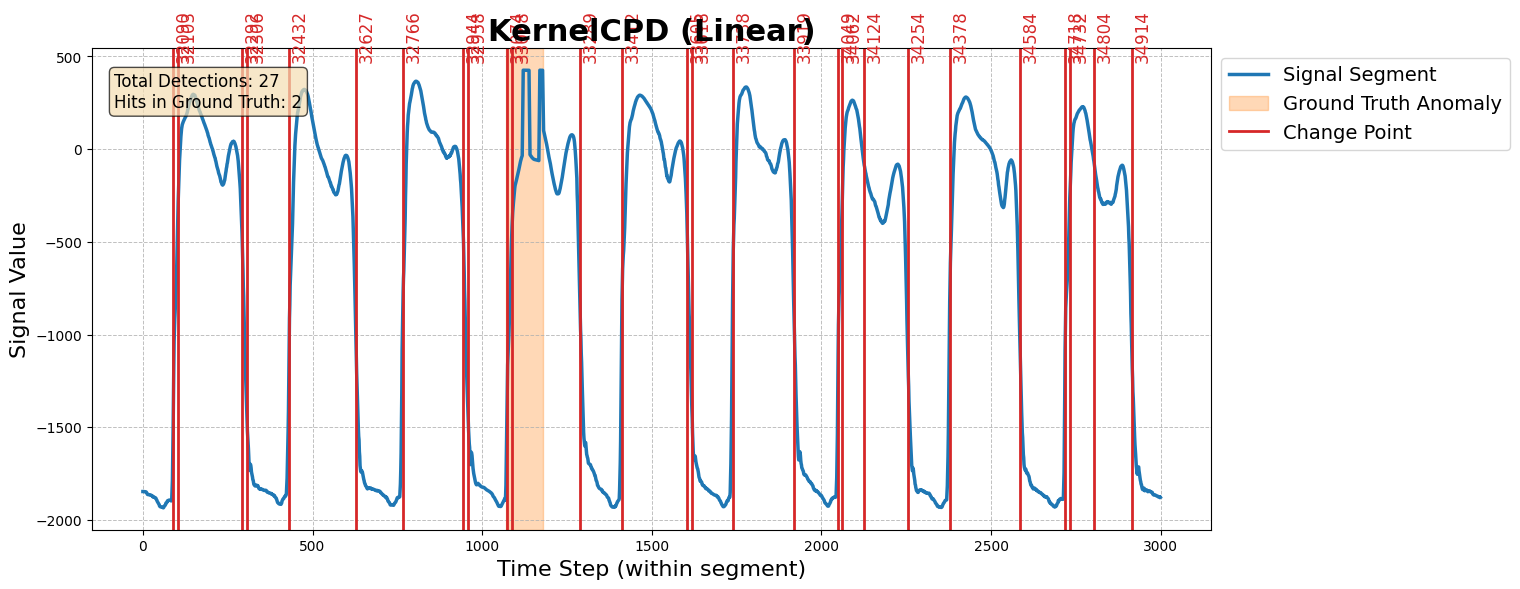

-> Processing: Pelt (Rank)...


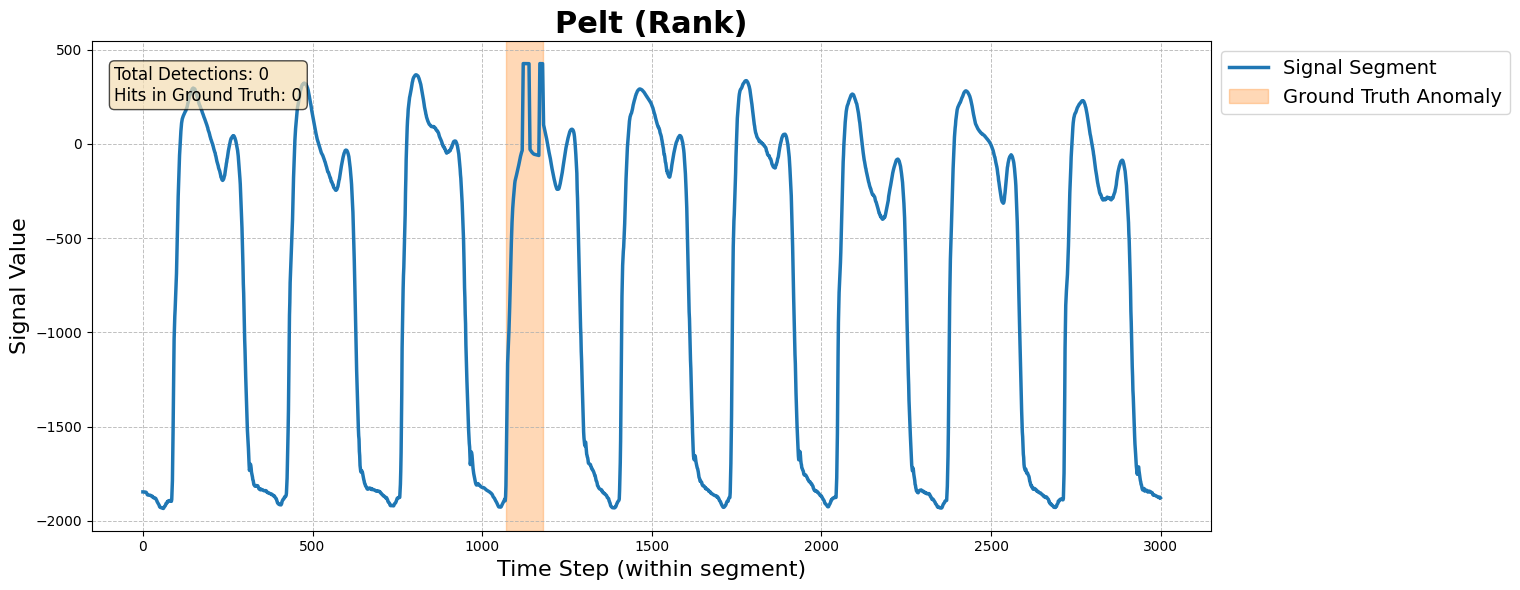

-> Processing: Pelt (Gaussian)...


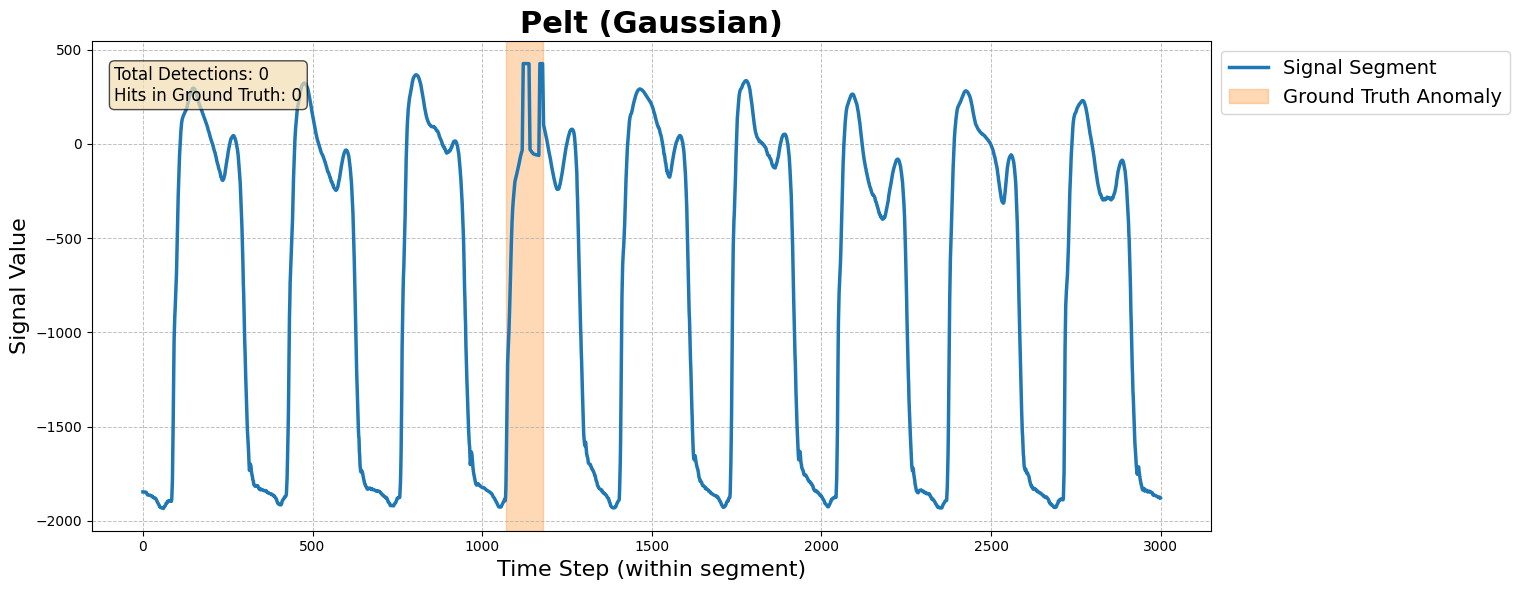

-> Processing: BinSeg (Gaussian)...


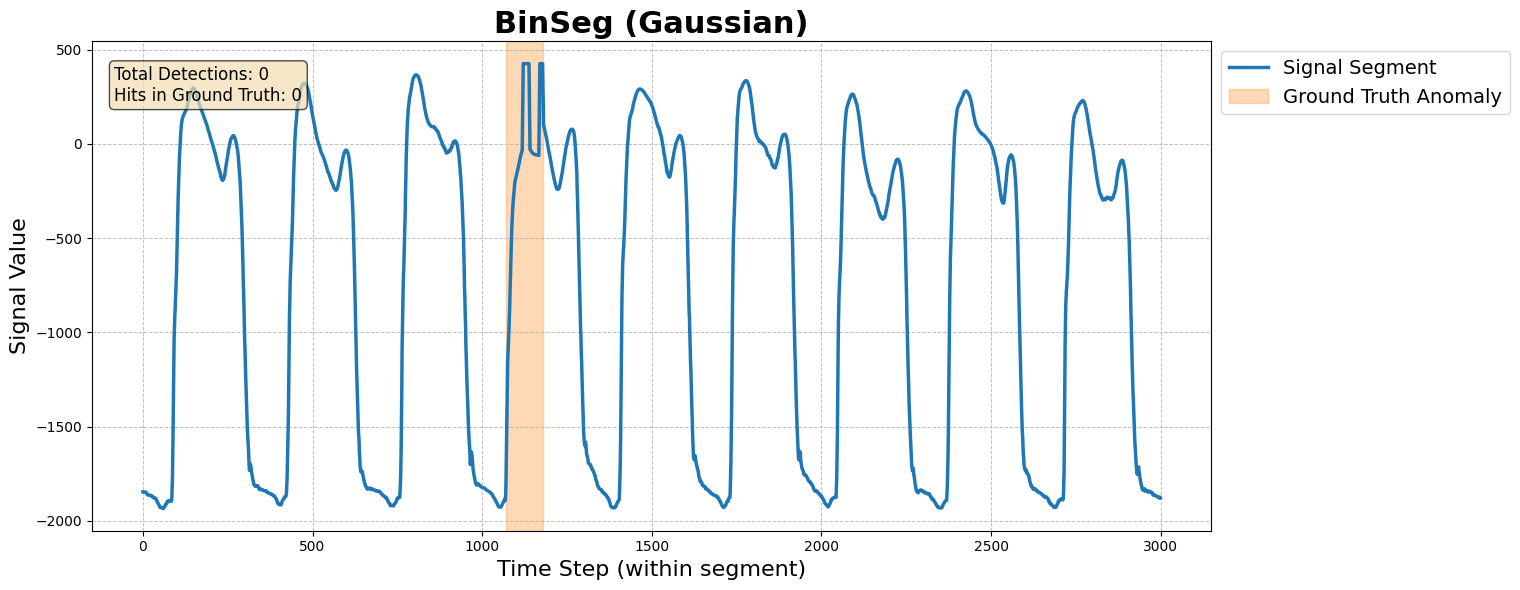

-> Processing: BottomUp (L2)...


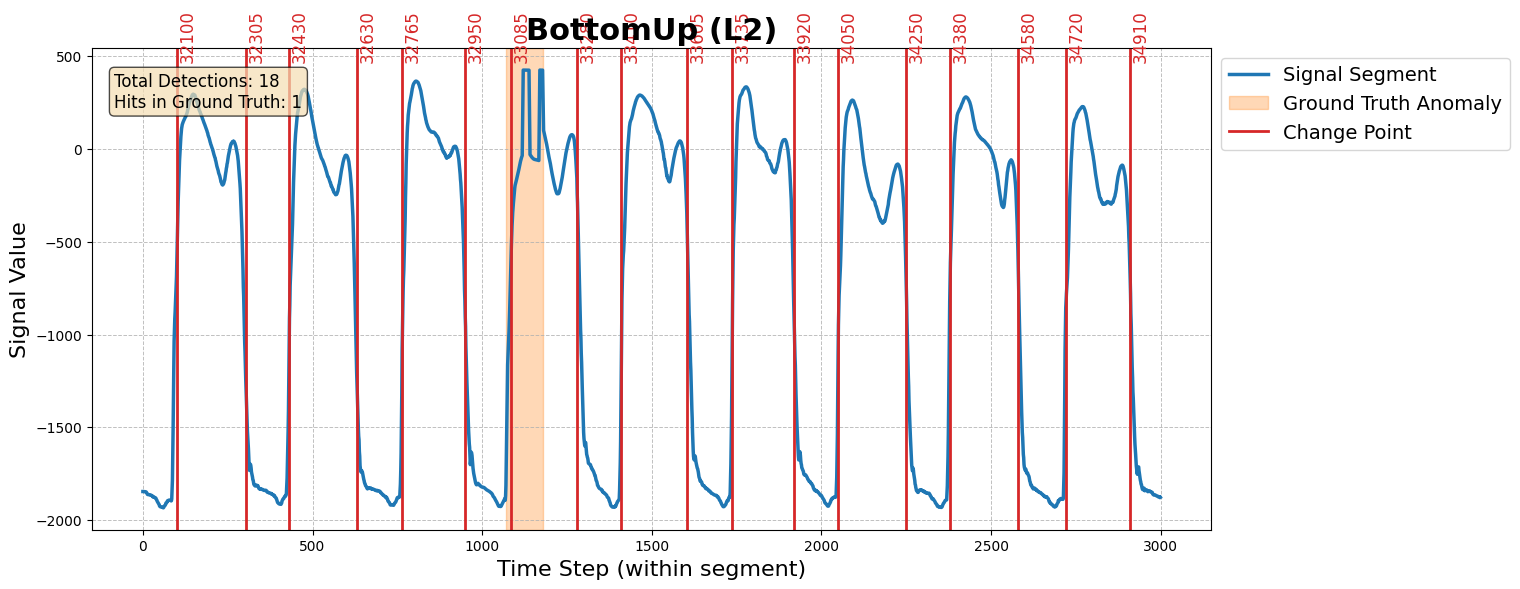


--- PERFORMANCE REPORT (WITHOUT FOURIER FILTERING) ---
                   Precision   Recall F1-Score  Detections  Hits in GT
Pelt (L2)              5.56%  100.00%    0.105          18           1
BinSeg (L2)            5.56%  100.00%    0.105          18           1
Window (L2)            0.00%    0.00%    0.000           0           0
KernelCPD (Linear)     7.41%  100.00%    0.138          27           2
Pelt (Rank)            0.00%    0.00%    0.000           0           0
Pelt (Gaussian)        0.00%    0.00%    0.000           0           0
BinSeg (Gaussian)      0.00%    0.00%    0.000           0           0
BottomUp (L2)          5.56%  100.00%    0.105          18           1

 Best Performing Algorithm (by F1-Score): KernelCPD (Linear)


In [13]:
import numpy as np
import matplotlib.pyplot as plt
import ruptures as rpt
import pandas as pd
import warnings

warnings.filterwarnings("ignore")

FILE_PATH = '170_UCR_Anomaly_gaitHunt1_18500_33070_33180.txt'
SEGMENT_START = 32000
SEGMENT_END = 35000
GROUND_TRUTH_START = 33070
GROUND_TRUTH_END = 33180
CHOSEN_MULTIPLIER = 6

def load_full_signal(path):
    return np.loadtxt(path).flatten()

def extract_segment(signal, start, end):
    return signal[start:end]

def compute_penalty(signal, multiplier):
    sigma = np.std(signal)
    return multiplier * np.log(len(signal)) * (sigma ** 2)

def detect_changepoints(algorithm, signal, penalty):
    
    if isinstance(algorithm, rpt.KernelCPD):
        num_bkps = int(np.sqrt(len(signal)) / 2)
        algorithm.fit(signal)
        return algorithm.predict(n_bkps=num_bkps)
    else:
        algorithm.fit(signal)
        return algorithm.predict(pen=penalty)


def calculate_metrics(detected_changepoints, gt_start, gt_end):
    points = detected_changepoints[:-1] 
    true_positives = sum(1 for p in points if gt_start <= p < gt_end)
    false_positives = len(points) - true_positives
    
    
    false_negatives = 1 - int(true_positives > 0)
    
    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
    f1_score = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    
    return {
        'Precision': precision, 
        'Recall': recall, 
        'F1-Score': f1_score, 
        'Detections': len(points),
        'Hits in GT': true_positives
    }

def plot_signal_with_changepoints(signal, changepoints, segment_start_index, gt_start, gt_end, title, total_detections, hits_in_gt):
    fig, ax = plt.subplots(figsize=(18, 6))
    
    region_start = gt_start - segment_start_index
    region_end = gt_end - segment_start_index
    
    ax.plot(signal, color='C0', linewidth=2.5, label='Signal Segment')
    ax.axvspan(region_start, region_end, color='C1', alpha=0.3, label='Ground Truth Anomaly')
    
    if changepoints and len(changepoints) > 1:
        is_first_label = True
        for cp in changepoints[:-1]:
            label = 'Change Point' if is_first_label else ""
            ax.axvline(cp, color='C3', linestyle='-', linewidth=2, label=label)
            ax.text(cp + 5, ax.get_ylim()[1] * 0.9, str(cp + segment_start_index), rotation=90, fontsize=12, color='C3')
            is_first_label = False

    ax.set_title(title, fontsize=22, fontweight='bold')
    ax.set_xlabel('Time Step (within segment)', fontsize=16)
    ax.set_ylabel('Signal Value', fontsize=16)
    ax.grid(True, linestyle='--', linewidth=0.7, alpha=0.8)
    
    summary_text = f"Total Detections: {total_detections}\nHits in Ground Truth: {hits_in_gt}"
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.7)
    ax.text(0.02, 0.95, summary_text, transform=ax.transAxes, fontsize=12,
            verticalalignment='top', bbox=props)
    
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=14)
    fig.tight_layout(rect=[0, 0, 0.85, 1])
    
    plt.show()

def performance_report(metrics_dict):
    df = pd.DataFrame.from_dict(metrics_dict, orient='index')
    
    report_df = df[['Precision', 'Recall', 'F1-Score', 'Detections', 'Hits in GT']].copy()
    report_df['Precision'] = report_df['Precision'].map('{:.2%}'.format)
    report_df['Recall'] = report_df['Recall'].map('{:.2%}'.format)
    report_df['F1-Score'] = report_df['F1-Score'].map('{:.3f}'.format)
    
    print("\n--- PERFORMANCE REPORT (WITHOUT FOURIER FILTERING) ---")
    print(report_df)
    
    best_algorithm = df['F1-Score'].astype(float).idxmax()
    print(f"\n Best Performing Algorithm (by F1-Score): {best_algorithm}")

def main():
    full_signal = load_full_signal(FILE_PATH)
    segment = extract_segment(full_signal, SEGMENT_START, SEGMENT_END)
    
    penalty = compute_penalty(segment, CHOSEN_MULTIPLIER)

    algorithms = {
        'Pelt (L2)': rpt.Pelt(model='l2'),
        'BinSeg (L2)': rpt.Binseg(model='l2'),
        'Window (L2)': rpt.Window(model='l2', width=100),
        'KernelCPD (Linear)': rpt.KernelCPD(kernel='linear'),
        'Pelt (Rank)': rpt.Pelt(model='rank'),
        'Pelt (Gaussian)': rpt.Pelt(model='normal'),
        'BinSeg (Gaussian)': rpt.Binseg(model='normal'),
        'BottomUp (L2)': rpt.BottomUp(model='l2')
    }

    results = {}
    print("--- Running Comparison Algorithms on Original Signal ---")
    for name, algorithm in algorithms.items():
        print(f"-> Processing: {name}...")
        
        changepoints = detect_changepoints(algorithm, segment.reshape(-1, 1), penalty=penalty)
        
        scores = calculate_metrics(
            changepoints, 
            GROUND_TRUTH_START - SEGMENT_START, 
            GROUND_TRUTH_END - SEGMENT_START
        )
        
        plot_signal_with_changepoints(
            signal=segment, 
            changepoints=changepoints, 
            segment_start_index=SEGMENT_START, 
            gt_start=GROUND_TRUTH_START, 
            gt_end=GROUND_TRUTH_END, 
            title=name,
            total_detections=scores['Detections'],
            hits_in_gt=scores['Hits in GT']
        )
        
        results[name] = scores

    performance_report(results)

if __name__ == '__main__':
    main()

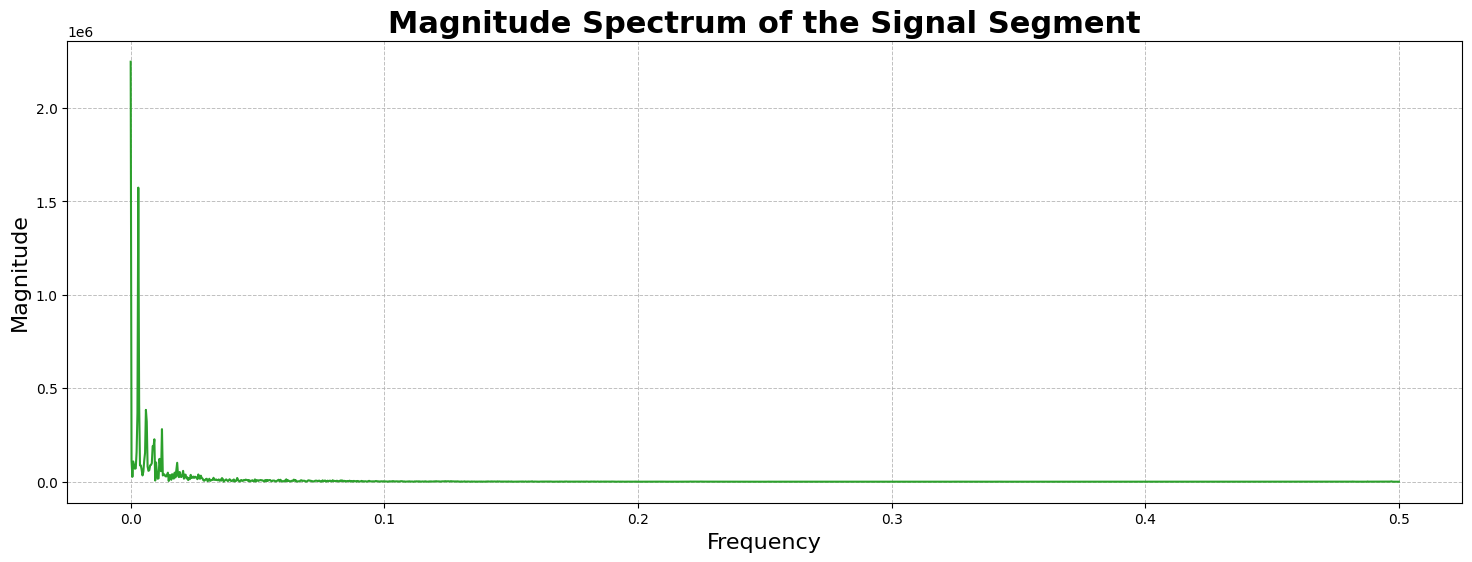

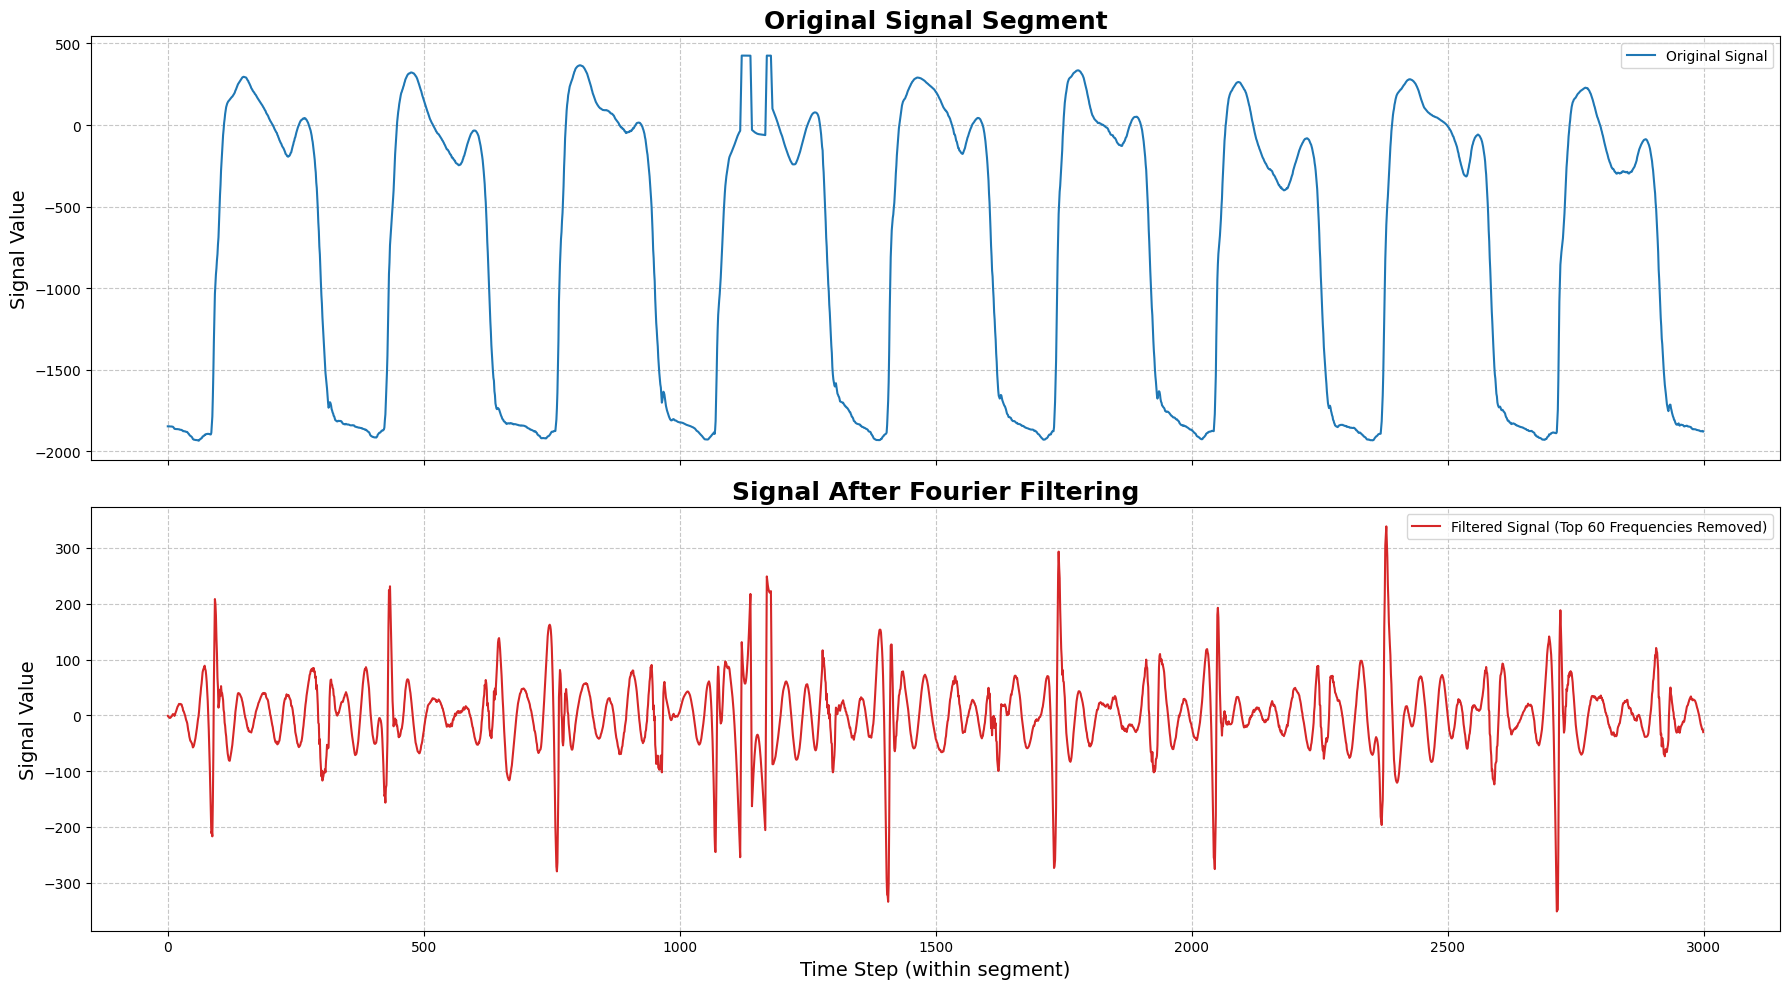

In [15]:
import numpy as np
import matplotlib.pyplot as plt

FILE_PATH = '170_UCR_Anomaly_gaitHunt1_18500_33070_33180.txt'
SEGMENT_START = 32000
SEGMENT_END = 35000
FFT_FILTER_TOP_K = 60

def load_full_signal(path):
    return np.loadtxt(path).flatten()

def extract_segment(signal, start, end):
    return signal[start:end]

def analyze_and_filter_with_fft(signal, k):
    fft_vals = np.fft.rfft(signal)
    fft_mag = np.abs(fft_vals)
    fft_freq = np.fft.rfftfreq(len(signal))
    
    plt.figure(figsize=(18, 6))
    plt.plot(fft_freq, fft_mag, color='C2')
    plt.title('Magnitude Spectrum of the Signal Segment', fontsize=22, fontweight='bold')
    plt.xlabel('Frequency', fontsize=16)
    plt.ylabel('Magnitude', fontsize=16)
    plt.grid(True, linestyle='--', linewidth=0.7, alpha=0.8)
    plt.show()

    
    dominant_indices = np.argsort(fft_mag)[-k:]
    
    fft_vals_filtered = fft_vals.copy()
    
    fft_vals_filtered[dominant_indices] = 0
    
    filtered_signal = np.fft.irfft(fft_vals_filtered, n=len(signal))
    
    return filtered_signal

def plot_original_vs_filtered(original_signal, filtered_signal):
    fig, ax = plt.subplots(2, 1, figsize=(18, 10), sharex=True)
    
    ax[0].plot(original_signal, color='C0', label='Original Signal')
    ax[0].set_title('Original Signal Segment', fontsize=18, fontweight='bold')
    ax[0].set_ylabel('Signal Value', fontsize=14)
    ax[0].grid(True, linestyle='--', alpha=0.7)
    ax[0].legend()
    
    ax[1].plot(filtered_signal, color='C3', label=f'Filtered Signal (Top {FFT_FILTER_TOP_K} Frequencies Removed)')
    ax[1].set_title('Signal After Fourier Filtering', fontsize=18, fontweight='bold')
    ax[1].set_xlabel('Time Step (within segment)', fontsize=14)
    ax[1].set_ylabel('Signal Value', fontsize=14)
    ax[1].grid(True, linestyle='--', alpha=0.7)
    ax[1].legend()

    plt.tight_layout()
    plt.show()

def main():
    full_signal = load_full_signal(FILE_PATH)
    segment = extract_segment(full_signal, SEGMENT_START, SEGMENT_END)
    
    filtered_segment = analyze_and_filter_with_fft(segment, FFT_FILTER_TOP_K)
    
    plot_original_vs_filtered(segment, filtered_segment)

if __name__ == '__main__':
    main()

--- Running Comparison Algorithms on Filtered Signal ---
-> Processing: Pelt (L2)...


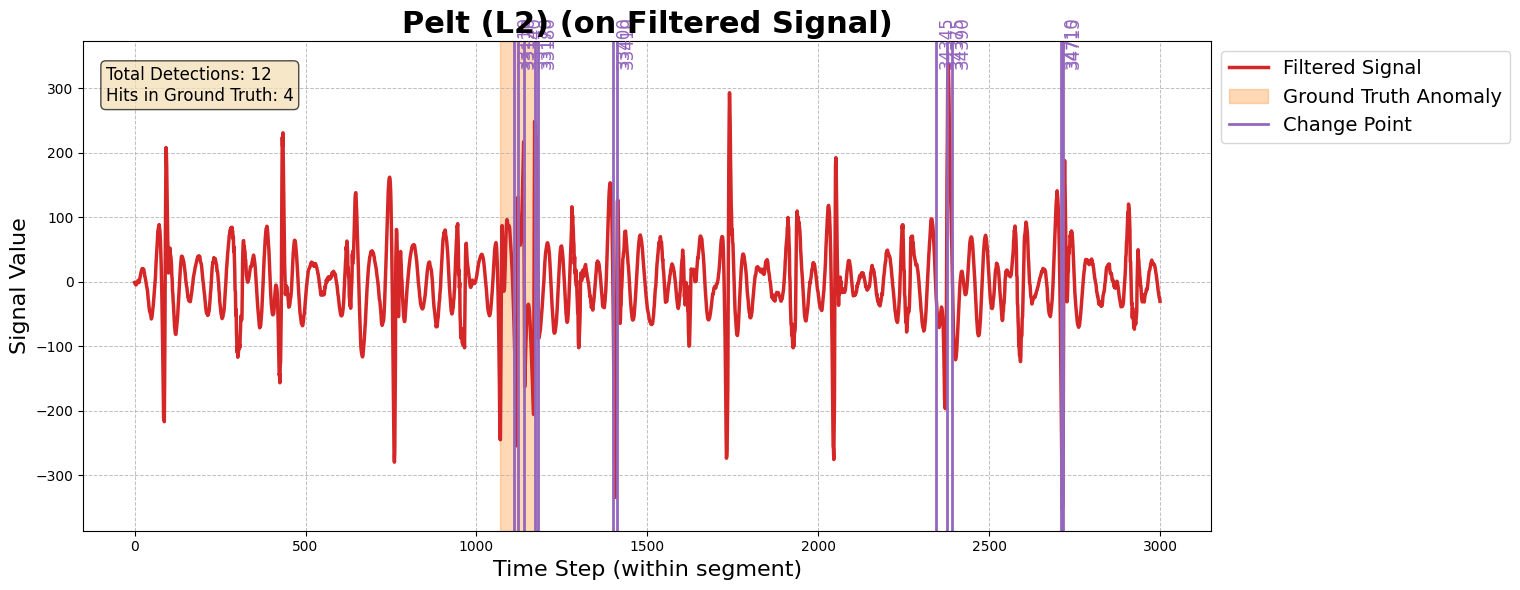

-> Processing: BinSeg (L2)...


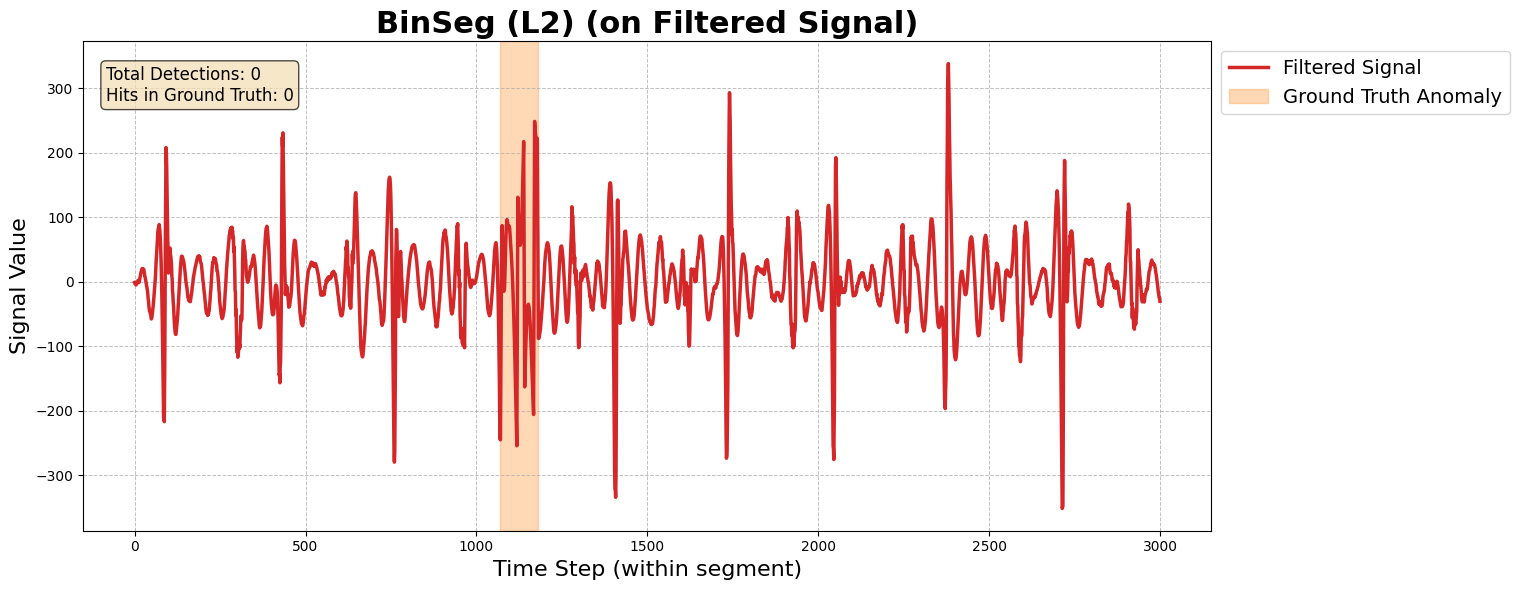

-> Processing: Window (L2)...


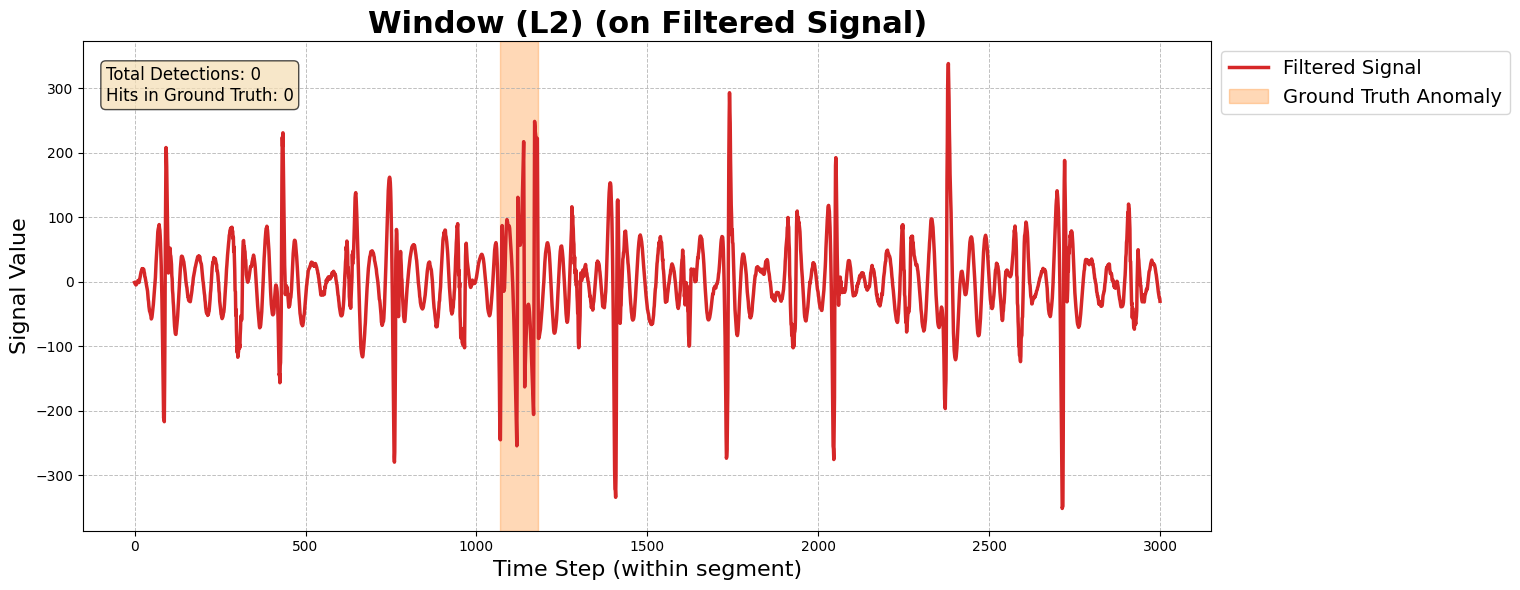

-> Processing: KernelCPD (Linear)...


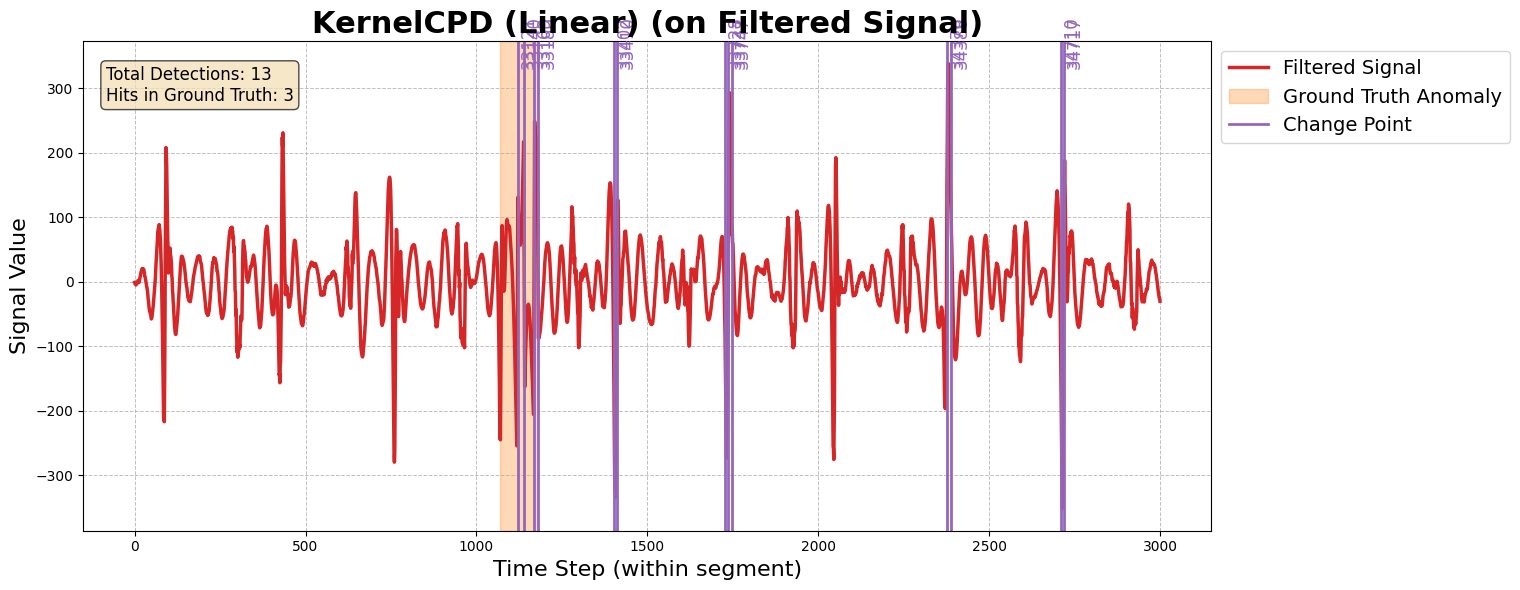

-> Processing: Pelt (Rank)...


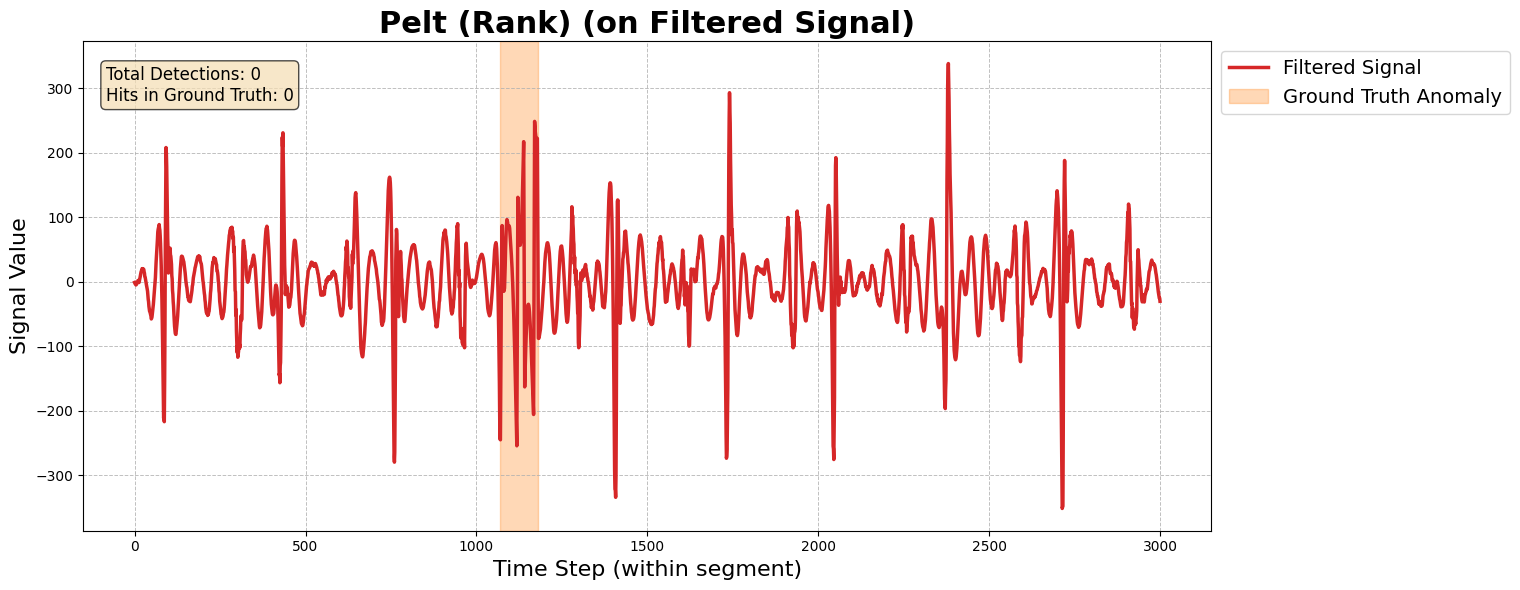

-> Processing: Pelt (Gaussian)...


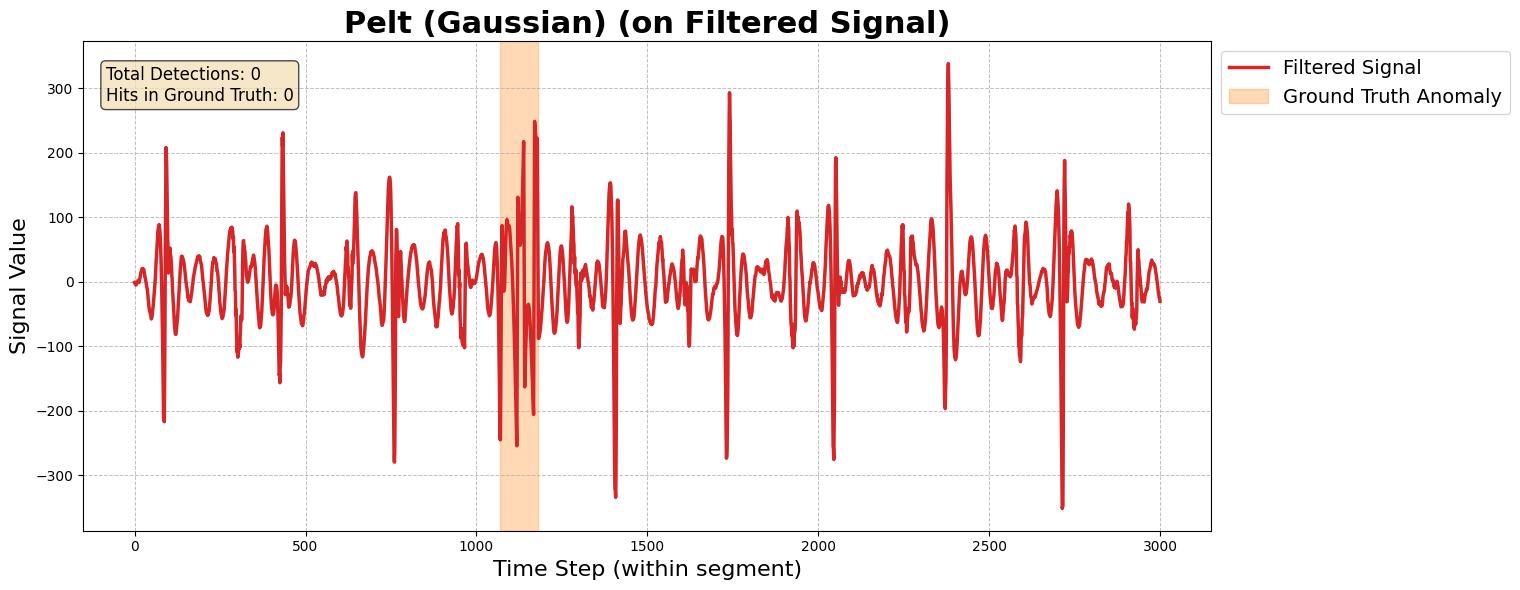

-> Processing: BinSeg (Gaussian)...


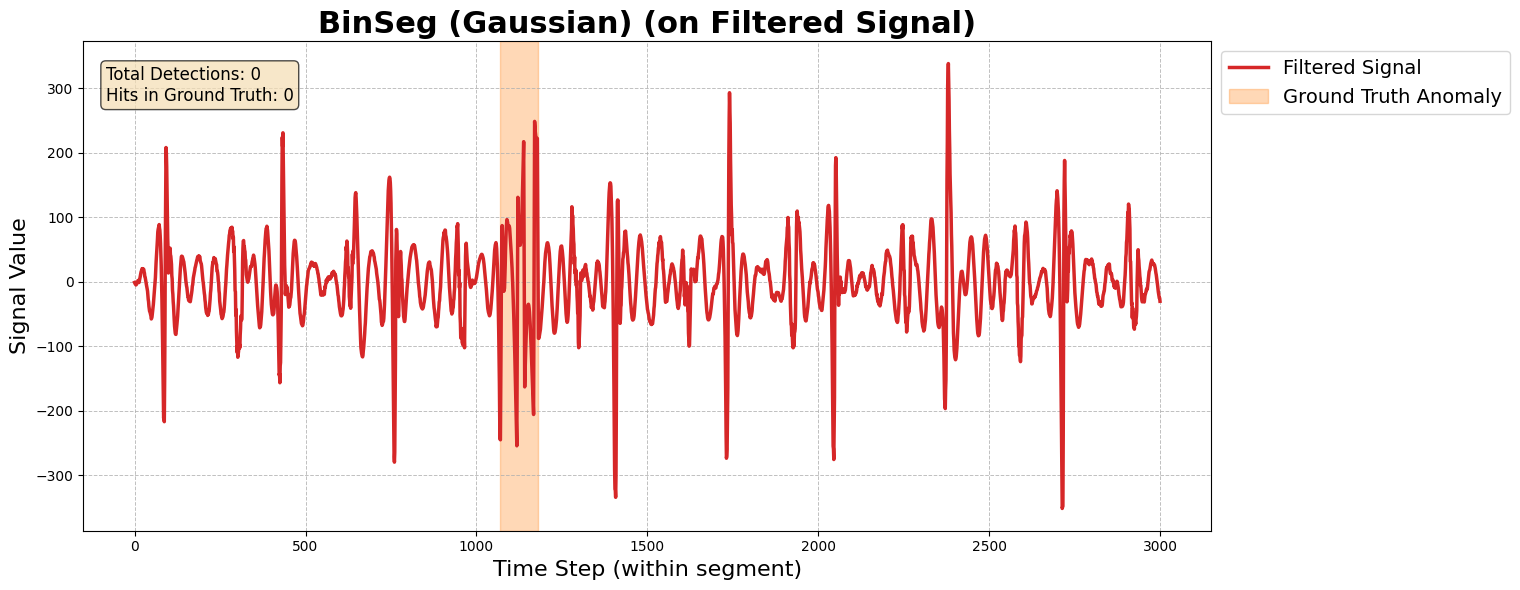

-> Processing: BottomUp (L2)...


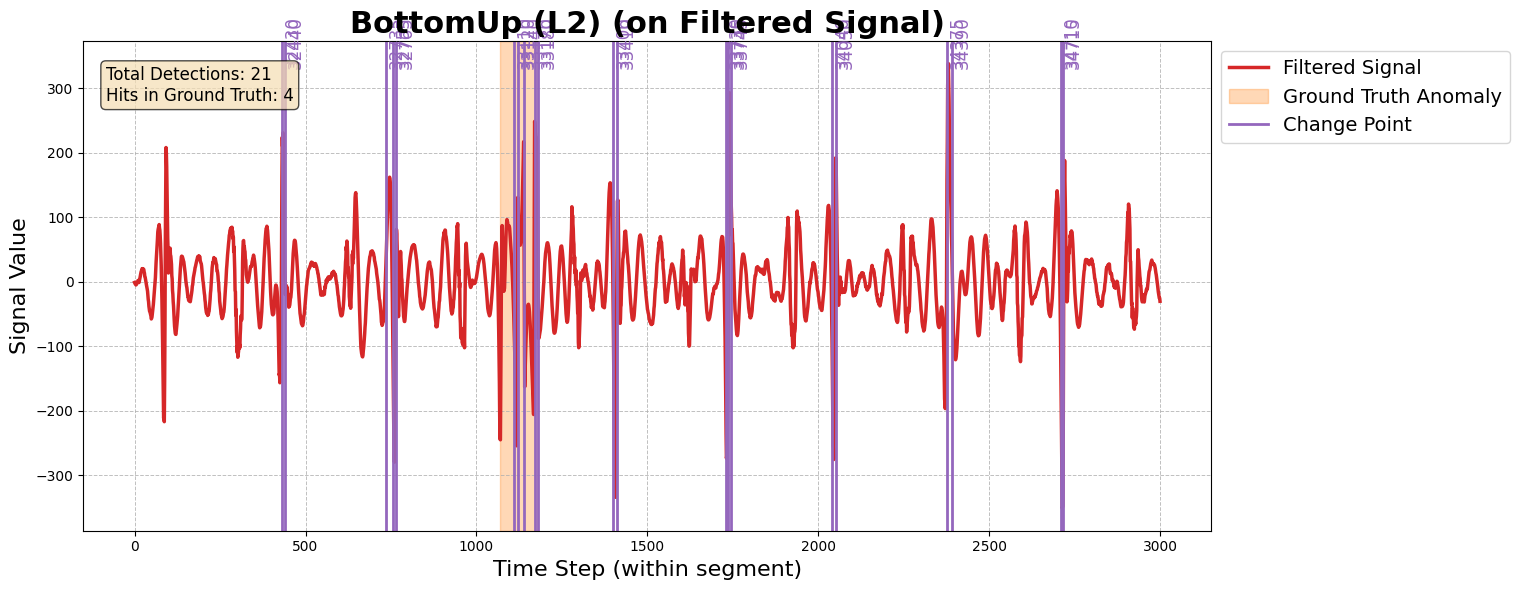


--- PERFORMANCE REPORT (WITH FOURIER FILTERING) ---
                   Precision   Recall F1-Score  Detections  Hits in GT
Pelt (L2)             33.33%  100.00%    0.500          12           4
BinSeg (L2)            0.00%    0.00%    0.000           0           0
Window (L2)            0.00%    0.00%    0.000           0           0
KernelCPD (Linear)    23.08%  100.00%    0.375          13           3
Pelt (Rank)            0.00%    0.00%    0.000           0           0
Pelt (Gaussian)        0.00%    0.00%    0.000           0           0
BinSeg (Gaussian)      0.00%    0.00%    0.000           0           0
BottomUp (L2)         19.05%  100.00%    0.320          21           4

 Best Performing Algorithm (by F1-Score): Pelt (L2)


In [17]:
import numpy as np
import matplotlib.pyplot as plt
import ruptures as rpt
import pandas as pd
import warnings

warnings.filterwarnings("ignore")

FILE_PATH = '170_UCR_Anomaly_gaitHunt1_18500_33070_33180.txt'
SEGMENT_START = 32000
SEGMENT_END = 35000
GROUND_TRUTH_START = 33070
GROUND_TRUTH_END = 33180
FFT_FILTER_TOP_K = 60
CHOSEN_MULTIPLIER = 6

def load_full_signal(path):
    return np.loadtxt(path).flatten()

def extract_segment(signal, start, end):
    return signal[start:end]

def remove_dominant_frequencies(signal, k):
    fft_vals = np.fft.rfft(signal)
    dominant_indices = np.argsort(np.abs(fft_vals))[-k:]
    fft_vals[dominant_indices] = 0
    return np.fft.irfft(fft_vals, n=len(signal))

def compute_penalty(signal, multiplier):
    sigma = np.std(signal)
    return multiplier * np.log(len(signal)) * (sigma ** 2)

def detect_changepoints(algorithm, signal, penalty):
    if isinstance(algorithm, rpt.KernelCPD):
        num_bkps = int(np.sqrt(len(signal)) / 4) 
        algorithm.fit(signal)
        return algorithm.predict(n_bkps=num_bkps)
    else:
        algorithm.fit(signal)
        return algorithm.predict(pen=penalty)

def calculate_metrics(detected_changepoints, gt_start, gt_end):
    points = detected_changepoints[:-1]
    true_positives = sum(1 for p in points if gt_start <= p < gt_end)
    false_positives = len(points) - true_positives
    false_negatives = 1 - int(true_positives > 0)
    
    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
    f1_score = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    
    return {
        'Precision': precision, 
        'Recall': recall, 
        'F1-Score': f1_score, 
        'Detections': len(points),
        'Hits in GT': true_positives
    }

def plot_signal_with_changepoints(signal, changepoints, segment_start_index, gt_start, gt_end, title, total_detections, hits_in_gt):
    fig, ax = plt.subplots(figsize=(18, 6))
    
    region_start = gt_start - segment_start_index
    region_end = gt_end - segment_start_index
    
    ax.plot(signal, color='C3', linewidth=2.5, label='Filtered Signal')
    ax.axvspan(region_start, region_end, color='C1', alpha=0.3, label='Ground Truth Anomaly')
    
    if changepoints and len(changepoints) > 1:
        is_first_label = True
        for cp in changepoints[:-1]:
            label = 'Change Point' if is_first_label else ""
            ax.axvline(cp, color='C4', linestyle='-', linewidth=2, label=label)
            ax.text(cp + 5, ax.get_ylim()[1] * 0.9, str(cp + segment_start_index), rotation=90, fontsize=12, color='C4')
            is_first_label = False

    ax.set_title(title, fontsize=22, fontweight='bold')
    ax.set_xlabel('Time Step (within segment)', fontsize=16)
    ax.set_ylabel('Signal Value', fontsize=16)
    ax.grid(True, linestyle='--', linewidth=0.7, alpha=0.8)
    
    summary_text = f"Total Detections: {total_detections}\nHits in Ground Truth: {hits_in_gt}"
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.7)
    ax.text(0.02, 0.95, summary_text, transform=ax.transAxes, fontsize=12,
            verticalalignment='top', bbox=props)
    
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=14)
    fig.tight_layout(rect=[0, 0, 0.85, 1])
    
    plt.show()

def performance_report(metrics_dict, title):
    df = pd.DataFrame.from_dict(metrics_dict, orient='index')
    
    report_df = df[['Precision', 'Recall', 'F1-Score', 'Detections', 'Hits in GT']].copy()
    report_df['Precision'] = report_df['Precision'].map('{:.2%}'.format)
    report_df['Recall'] = report_df['Recall'].map('{:.2%}'.format)
    report_df['F1-Score'] = report_df['F1-Score'].map('{:.3f}'.format)
    
    print(f"\n--- {title} ---")
    print(report_df)
    
    if not df.empty and 'F1-Score' in df.columns and df['F1-Score'].notna().any():
        best_algorithm = df['F1-Score'].astype(float).idxmax()
        print(f"\n Best Performing Algorithm (by F1-Score): {best_algorithm}")
    else:
        print("\nNo valid F1-scores to determine the best algorithm.")

def main():
    full_signal = load_full_signal(FILE_PATH)
    segment = extract_segment(full_signal, SEGMENT_START, SEGMENT_END)
    
    filtered_segment = remove_dominant_frequencies(segment, FFT_FILTER_TOP_K)
    
    penalty = compute_penalty(filtered_segment, CHOSEN_MULTIPLIER)

    algorithms = {
        'Pelt (L2)': rpt.Pelt(model='l2'),
        'BinSeg (L2)': rpt.Binseg(model='l2'),
        'Window (L2)': rpt.Window(model='l2', width=100),
        'KernelCPD (Linear)': rpt.KernelCPD(kernel='linear'),
        'Pelt (Rank)': rpt.Pelt(model='rank'),
        'Pelt (Gaussian)': rpt.Pelt(model='normal'),
        'BinSeg (Gaussian)': rpt.Binseg(model='normal'),
        'BottomUp (L2)': rpt.BottomUp(model='l2')
    }

    results_filtered = {}
    print("--- Running Comparison Algorithms on Filtered Signal ---")
    for name, algorithm in algorithms.items():
        print(f"-> Processing: {name}...")
        
        changepoints = detect_changepoints(algorithm, filtered_segment.reshape(-1, 1), penalty=penalty)
        
        scores = calculate_metrics(
            changepoints, 
            GROUND_TRUTH_START - SEGMENT_START, 
            GROUND_TRUTH_END - SEGMENT_START
        )
        
        plot_signal_with_changepoints(
            signal=filtered_segment, 
            changepoints=changepoints, 
            segment_start_index=SEGMENT_START, 
            gt_start=GROUND_TRUTH_START, 
            gt_end=GROUND_TRUTH_END, 
            title=f"{name} (on Filtered Signal)",
            total_detections=scores['Detections'],
            hits_in_gt=scores['Hits in GT']
        )
        
        results_filtered[name] = scores

    performance_report(results_filtered, "PERFORMANCE REPORT (WITH FOURIER FILTERING)")

if __name__ == '__main__':
    main()

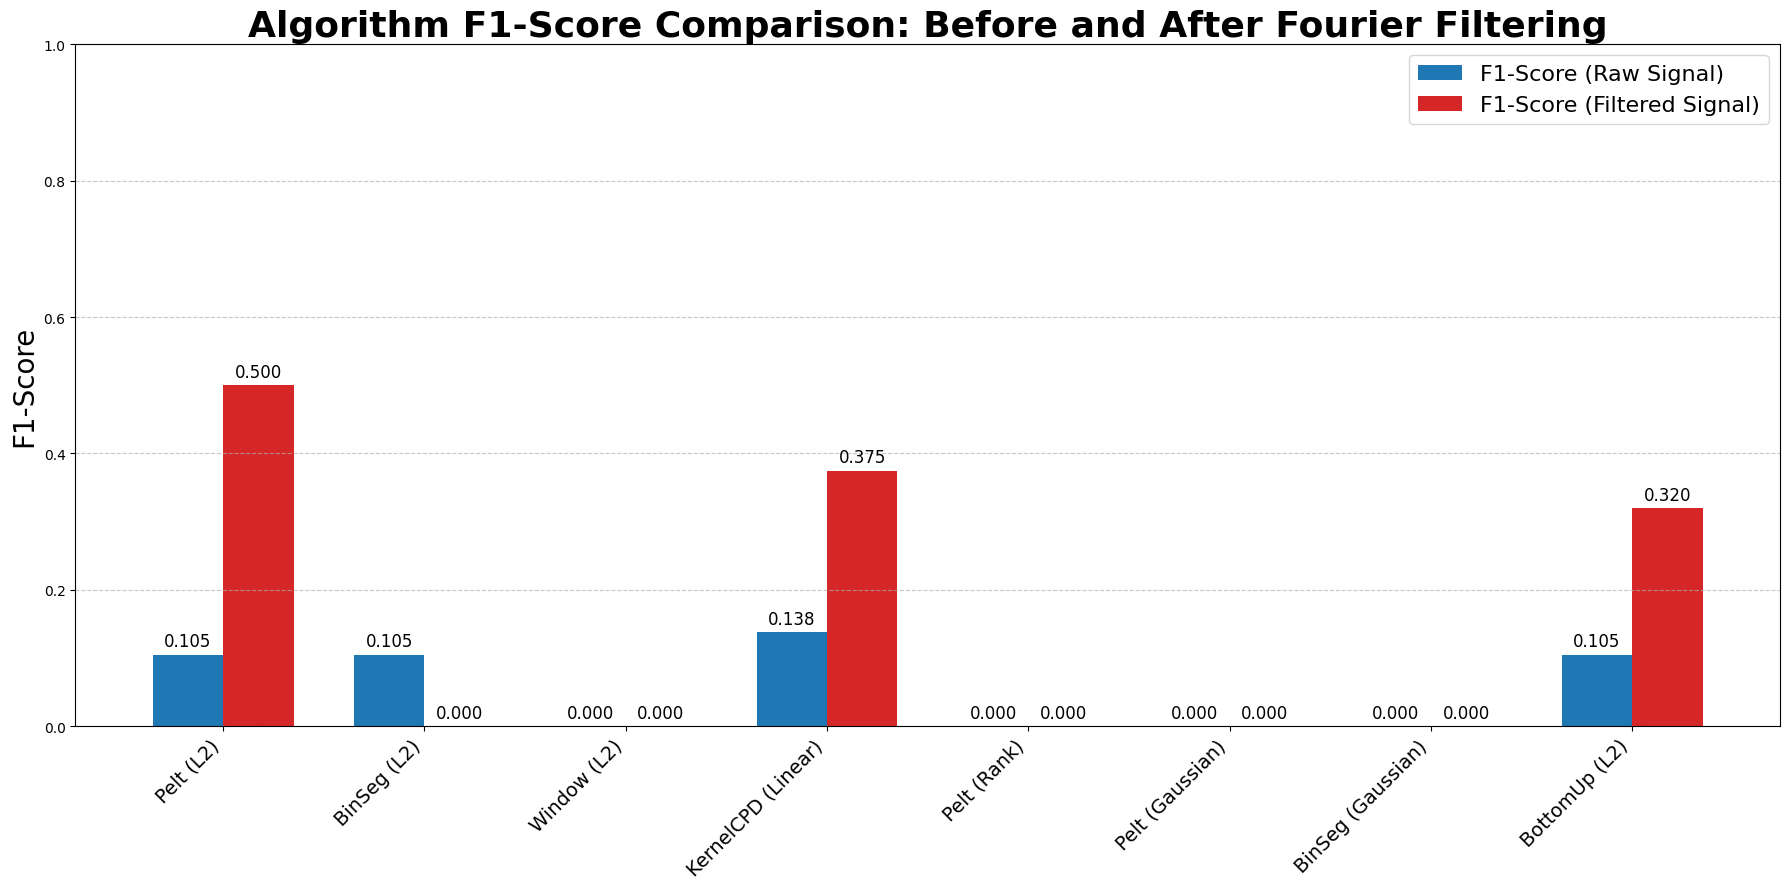

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def plot_performance_comparison(raw_results, filtered_results):
    df_raw = pd.DataFrame.from_dict(raw_results, orient='index')
    df_filtered = pd.DataFrame.from_dict(filtered_results, orient='index')

    f1_scores_raw = df_raw['F1-Score']
    f1_scores_filtered = df_filtered['F1-Score']

    labels = df_raw.index
    x = np.arange(len(labels)) 
    width = 0.35  

    fig, ax = plt.subplots(figsize=(18, 9))
    rects1 = ax.bar(x - width/2, f1_scores_raw, width, label='F1-Score (Raw Signal)', color='C0')
    rects2 = ax.bar(x + width/2, f1_scores_filtered, width, label='F1-Score (Filtered Signal)', color='C3')

    ax.set_ylabel('F1-Score', fontsize=20)
    ax.set_title('Algorithm F1-Score Comparison: Before and After Fourier Filtering', fontsize=26, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=45, ha="right", fontsize=14)
    ax.legend(fontsize=16)
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    ax.set_ylim(0, 1.0)

    ax.bar_label(rects1, padding=3, fmt='%.3f', fontsize=12)
    ax.bar_label(rects2, padding=3, fmt='%.3f', fontsize=12)

    fig.tight_layout()
    plt.show()

def main():
    results_raw = {
        'Pelt (L2)': {'Precision': 0.0556, 'Recall': 1.0, 'F1-Score': 0.105, 'Detections': 18, 'Hits in GT': 1},
        'BinSeg (L2)': {'Precision': 0.0556, 'Recall': 1.0, 'F1-Score': 0.105, 'Detections': 18, 'Hits in GT': 1},
        'Window (L2)': {'Precision': 0.0, 'Recall': 0.0, 'F1-Score': 0.0, 'Detections': 0, 'Hits in GT': 0},
        'KernelCPD (Linear)': {'Precision': 0.0741, 'Recall': 1.0, 'F1-Score': 0.138, 'Detections': 27, 'Hits in GT': 2},
        'Pelt (Rank)': {'Precision': 0.0, 'Recall': 0.0, 'F1-Score': 0.0, 'Detections': 0, 'Hits in GT': 0},
        'Pelt (Gaussian)': {'Precision': 0.0, 'Recall': 0.0, 'F1-Score': 0.0, 'Detections': 0, 'Hits in GT': 0},
        'BinSeg (Gaussian)': {'Precision': 0.0, 'Recall': 0.0, 'F1-Score': 0.0, 'Detections': 0, 'Hits in GT': 0},
        'BottomUp (L2)': {'Precision': 0.0556, 'Recall': 1.0, 'F1-Score': 0.105, 'Detections': 18, 'Hits in GT': 1}
    }

    results_filtered = {
        'Pelt (L2)': {'Precision': 0.3333, 'Recall': 1.0, 'F1-Score': 0.500, 'Detections': 12, 'Hits in GT': 4},
        'BinSeg (L2)': {'Precision': 0.0, 'Recall': 0.0, 'F1-Score': 0.0, 'Detections': 0, 'Hits in GT': 0},
        'Window (L2)': {'Precision': 0.0, 'Recall': 0.0, 'F1-Score': 0.0, 'Detections': 0, 'Hits in GT': 0},
        'KernelCPD (Linear)': {'Precision': 0.2308, 'Recall': 1.0, 'F1-Score': 0.375, 'Detections': 13, 'Hits in GT': 3},
        'Pelt (Rank)': {'Precision': 0.0, 'Recall': 0.0, 'F1-Score': 0.0, 'Detections': 0, 'Hits in GT': 0},
        'Pelt (Gaussian)': {'Precision': 0.0, 'Recall': 0.0, 'F1-Score': 0.0, 'Detections': 0, 'Hits in GT': 0},
        'BinSeg (Gaussian)': {'Precision': 0.0, 'Recall': 0.0, 'F1-Score': 0.0, 'Detections': 0, 'Hits in GT': 0},
        'BottomUp (L2)': {'Precision': 0.1905, 'Recall': 1.0, 'F1-Score': 0.320, 'Detections': 21, 'Hits in GT': 4}
    }

    plot_performance_comparison(results_raw, results_filtered)

if __name__ == '__main__':
    main()